# Creating seperate DataFrames

To start, we'll read in our headline data with our clusters and create two DataFrames: one with points only in the United States, and all the points outside the US.

In [1]:
import pandas as pd
import numpy as np

df_world = pd.read_csv("data/clustered_headlines.csv")
df_us = df_world[df_world['countrycode']=='US']
df_world = df_world[df_world['countrycode']!='US']

In [2]:
# Based on the Haversine formula, found here: https://www.movable-type.co.uk/scripts/latlong.html
import math
def great_circle(point_1, point_2):
    RADIUS = 6371  # Kilometers, Earth's mean radius
    lat_1 = math.radians(point_1[0])
    lat_2 = math.radians(point_2[0])
    d_lat = lat_2 - lat_1
    d_long = math.radians(point_2[1] - point_1[1])
    a = math.sin(d_lat/2)**2 + math.cos(lat_1) * math.cos(lat_2) * math.sin(d_long/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return RADIUS * c

In [3]:
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

world_plotter = Basemap()
# From Data Science Bookcamp: Plotting Maps using Basemap
us_plotter = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, llcrnrlat=22,
                     urcrnrlon=-64, urcrnrlat=49, lat_1=33, lat_2=45)

In [4]:
# Helper function to eliminate redundant code while plotting cluster maps.
# Note that this function doesn't draw any countries/boundaries nor show the matplotlib map,
# so it is the caller's responsibility to plot the boundaries and map type they want.
def plot_clusters(data_frame, map_plotter):
    plt.figure(figsize=(20, 12))
    cluster_group = data_frame.groupby('cluster')
    for cluster_id, cluster in cluster_group:
        if cluster_id == -1: continue
        #map_plotter.scatter(np.array(cluster.longitude), np.array(cluster.latitude), latlon=True)
        map_plotter.scatter(cluster.longitude.to_numpy(), cluster.latitude.to_numpy(), latlon=True)
    plt.legend( [f"Cluster {cid}" for cid, _ in cluster_group if cid != -1], \
               loc="lower left", markerscale=2, fontsize="medium" )

# Re-clustering: World

Since the old clusters no longer apply to our dataset, we'll have to re-cluster both of our datasets, starting with the non-US points. For the world, we'll use the parameters `eps=9` and `min_samples=3`.

In [5]:
clusters = DBSCAN(eps=9, min_samples=3).fit_predict(df_world[['latitude', 'longitude']].to_numpy())
df_world['cluster'] = clusters

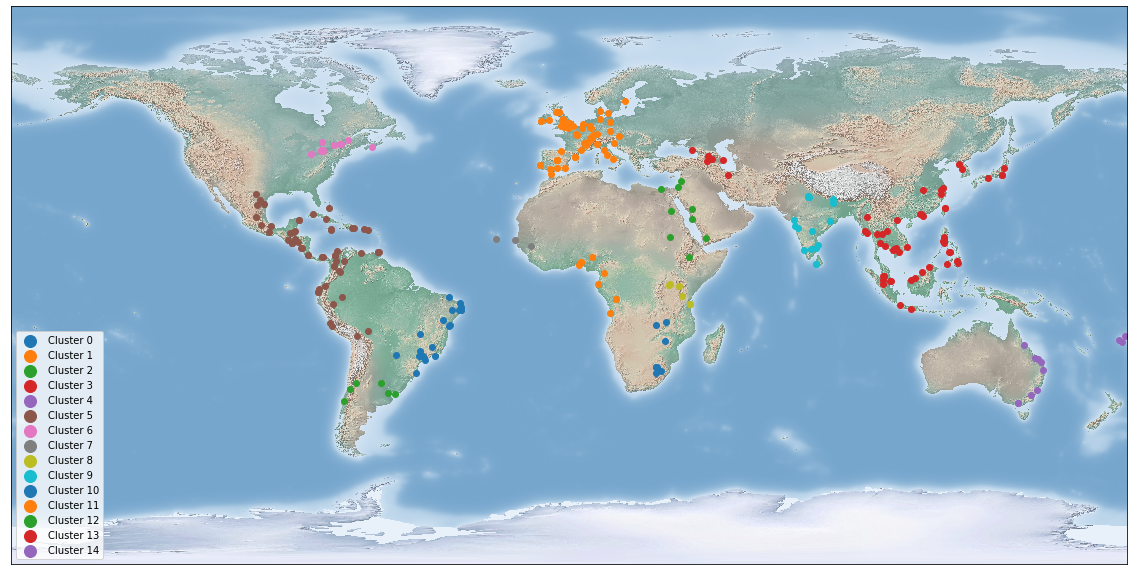

In [6]:
plot_clusters(df_world, world_plotter)
world_plotter.shadedrelief()
plt.show()

Looks good!

# Re-clustering: United States

Now, its time to recluster our United States data. We're probably going to try different parameters here, since the distance between cities is much smaller.

In [7]:
EPS = 2
MIN_SAMPLES = 3
clusters = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(df_us[['latitude', 'longitude']].to_numpy())
df_us['cluster'] = clusters

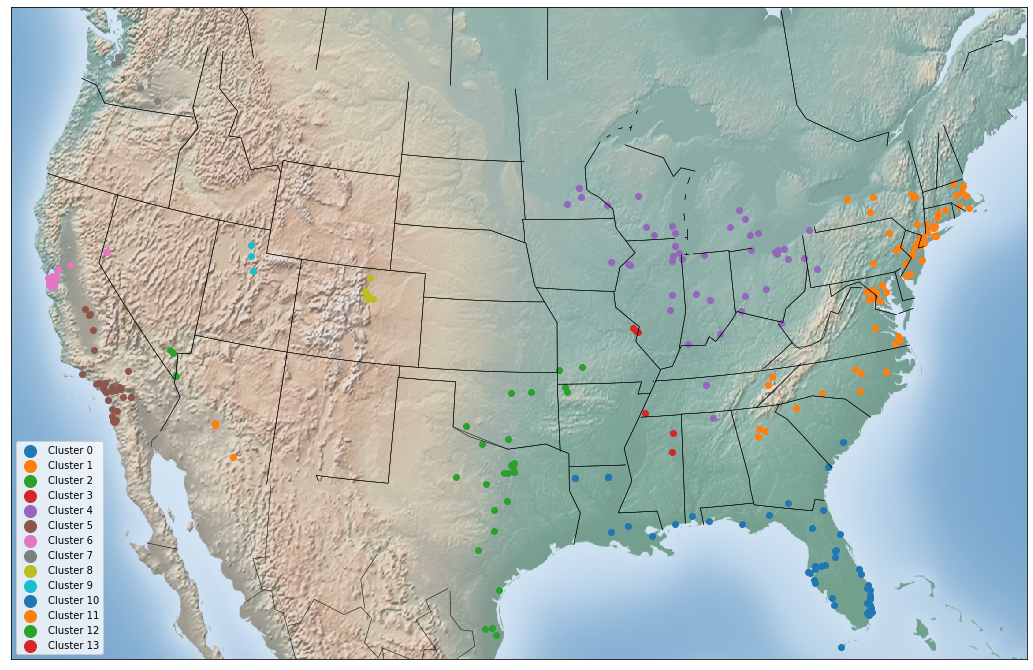

In [8]:
plot_clusters(df_us, us_plotter)
us_plotter.shadedrelief()
us_plotter.drawstates()
#plt.savefig(f"dbscan_{EPS}_{MIN_SAMPLES}.png", dpi=300, orientation="landscape")
plt.show()

In [27]:
df_us.groupby('cluster').count().sort_values('headline', ascending=False)

,headline,city,latitude,longitude,countrycode
cluster,,,,,
1,78,78,78,78,78
0,50,50,50,50,50
4,44,44,44,44,44
5,32,32,32,32,32
2,25,25,25,25,25
-1,23,23,23,23,23
6,15,15,15,15,15
8,7,7,7,7,7
7,6,6,6,6,6
